# Crime project report 

In this report, we are going to examine hate crime data from the United States between the years of 1991-2020. 

In [2]:
import pandas as pd 
import seaborn as sns 
import sklearn
import matplotlib as plt
from matplotlib import colors
from matplotlib import pyplot
import squarify

import pyspark 
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession

In [3]:
spark = SparkSession.builder \
    .master('local') \
    .appName('crime_project') \
    .getOrCreate()

In [4]:
df = pd.read_csv('hate_crime/hate_crime.csv')

/Users/youssefragab/opt/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
df.head()

,INCIDENT_ID,DATA_YEAR,ORI,PUB_AGENCY_NAME,PUB_AGENCY_UNIT,AGENCY_TYPE_NAME,STATE_ABBR,STATE_NAME,DIVISION_NAME,REGION_NAME,...,OFFENDER_RACE,OFFENDER_ETHNICITY,VICTIM_COUNT,OFFENSE_NAME,TOTAL_INDIVIDUAL_VICTIMS,LOCATION_NAME,BIAS_DESC,VICTIM_TYPES,MULTIPLE_OFFENSE,MULTIPLE_BIAS
0,3015,1991,AR0040200,Rogers,NaN,City,AR,Arkansas,West South Central,South,...,White,NaN,1,Intimidation,1.0,Highway/Road/Alley/Street/Sidewalk,Anti-Black or African American,Individual,S,S
1,3016,1991,AR0290100,Hope,NaN,City,AR,Arkansas,West South Central,South,...,Black or African American,NaN,1,Simple Assault,1.0,Highway/Road/Alley/Street/Sidewalk,Anti-White,Individual,S,S
2,43,1991,AR0350100,Pine Bluff,NaN,City,AR,Arkansas,West South Central,South,...,Black or African American,NaN,1,Aggravated Assault,1.0,Residence/Home,Anti-Black or African American,Individual,S,S
3,44,1991,AR0350100,Pine Bluff,NaN,City,AR,Arkansas,West South Central,South,...,Black or African American,NaN,2,Aggravated Assault;Destruction/Damage/Vandalis...,1.0,Highway/Road/Alley/Street/Sidewalk,Anti-White,Individual,M,S
4,3017,1991,AR0350100,Pine Bluff,NaN,City,AR,Arkansas,West South Central,South,...,Black or African American,NaN,1,Aggravated Assault,1.0,Service/Gas Station,Anti-White,Individual,S,S


In [5]:
len(df)

219073

As we can see, we have a dataframe with 28 rows and 219,073 rows. The first thing we are going to do is to do some date exploration to find out more about the data.

### Data Exploration

In [6]:
full_data = spark.read.csv('hate_crime/hate_crime.csv', header = True)

In [7]:
full_data.createOrReplaceTempView('full_data')

First, we are going to see how many entries we have in each year: 

In [8]:
incidents_year = spark.sql("SELECT DATA_YEAR AS YEAR, COUNT(INCIDENT_ID) AS INCIDENTS_PER_YEAR FROM FULL_DATA GROUP BY DATA_YEAR ORDER BY DATA_YEAR ASC")
incidents_year.show(30)

pd_incidents_year = incidents_year.toPandas()

+----+------------------+
|YEAR|INCIDENTS_PER_YEAR|
+----+------------------+
|1991|              4589|
|1992|              6667|
|1993|              7608|
|1994|              5954|
|1995|              7950|
|1996|              8790|
|1997|              8107|
|1998|              7902|
|1999|              7944|
|2000|              8219|
|2001|              9730|
|2002|              7485|
|2003|              7545|
|2004|              7685|
|2005|              7411|
|2006|              7715|
|2007|              7625|
|2008|              8039|
|2009|              6613|
|2010|              6633|
|2011|              6299|
|2012|              6594|
|2013|              6044|
|2014|              5599|
|2015|              5871|
|2016|              6276|
|2017|              7321|
|2018|              7171|
|2019|              7892|
|2020|              9795|
+----+------------------+



<AxesSubplot:xlabel='YEAR', ylabel='INCIDENTS_PER_YEAR'>

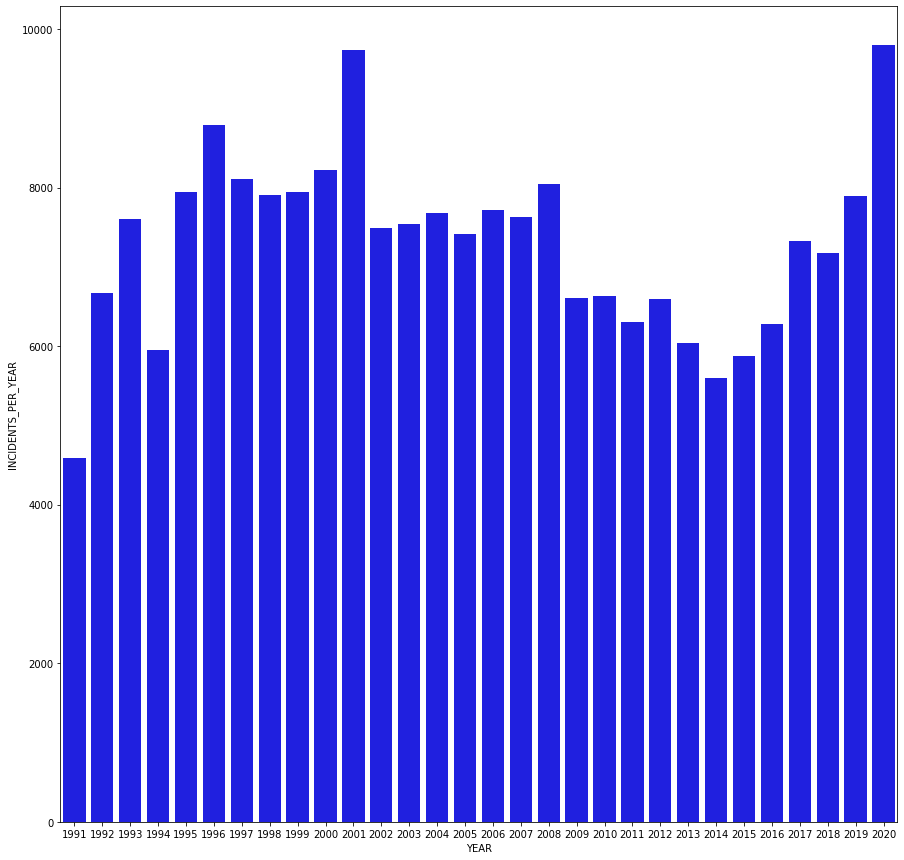

In [72]:
plt.pyplot.figure(figsize=(15,15))
sns.barplot(x = 'YEAR',
            y = 'INCIDENTS_PER_YEAR',
            data = pd_incidents_year,
            color = 'blue')

We can see from the bar plot that there is a lot of variation in the data. We have a peak around 2001, which is likely to correspond with the anti-Muslim sentiment that came with 9/11. The crimes stabilized until 2008, which is when the US got it's first Black president. And then we see the trend reversed, and hate crimes start going up again around 2016, which is when Barack Obama was replaced by Donald Trump in the White House. We are also currently experience a peak in hate crimes in the past 30 years. 

Next, it is interesting to see what different victim groups the data mentions, and then we can check to see which group had the most hate crimes against them for a particular year. 

In [11]:
spark.sql("SELECT DISTINCT(BIAS_DESC) FROM FULL_DATA").show(truncate = False)

+------------------------------------------------------------------------------------------------------+
|BIAS_DESC                                                                                             |
+------------------------------------------------------------------------------------------------------+
|Anti-Female;Anti-Mental Disability;Anti-White                                                         |
|Anti-Black or African American;Anti-Transgender                                                       |
|Anti-Black or African American;Anti-Mormon                                                            |
|Anti-Asian;Anti-Jewish                                                                                |
|Anti-Lesbian, Gay, Bisexual, or Transgender (Mixed Group);Anti-Other Race/Ethnicity/Ancestry          |
|Anti-Black or African American;Anti-Female                                                            |
|Anti-Bisexual;Anti-Jewish                             

So for the bias or racial motivation, the data is collected as a list of different biases that were present in the crime. We can check to see how many different combinations of biases we have in the data:

In [12]:
full_data.select('BIAS_DESC') \
    .groupBy('BIAS_DESC') \
    .count() \
    .orderBy('count', ascending = False) \
    .filter('count > 500') \
    .show(40,truncate = False)

+---------------------------------------------------------+-----+
|BIAS_DESC                                                |count|
+---------------------------------------------------------+-----+
|Anti-Black or African American                           |74646|
|Anti-Jewish                                              |28006|
|Anti-White                                               |25097|
|Anti-Gay (Male)                                          |21830|
|Anti-Hispanic or Latino                                  |14020|
|Anti-Other Race/Ethnicity/Ancestry                       |10751|
|Anti-Lesbian, Gay, Bisexual, or Transgender (Mixed Group)|6680 |
|Anti-Asian                                               |6419 |
|Anti-Multiple Races, Group                               |5212 |
|Anti-Lesbian (Female)                                    |4506 |
|Anti-Islamic (Muslim)                                    |3910 |
|Anti-Other Religion                                      |3518 |
|Anti-Amer

In [53]:
spark.sql("""
    SELECT first(BIAS_DESC) AS VICTIM_GROUP, DATA_YEAR, max(NUMBER_OF_INCIDENTS)
    FROM (SELECT BIAS_DESC, DATA_YEAR, COUNT(DATA_YEAR) AS NUMBER_OF_INCIDENTS 
        FROM FULL_DATA 
        GROUP BY BIAS_DESC, DATA_YEAR
        ORDER BY DATA_YEAR ASC, NUMBER_OF_INCIDENTS DESC)
    GROUP BY DATA_YEAR
    ORDER BY DATA_YEAR ASC
""").show(30, False)

+------------------------------+---------+------------------------+
|VICTIM_GROUP                  |DATA_YEAR|max(NUMBER_OF_INCIDENTS)|
+------------------------------+---------+------------------------+
|Anti-Black or African American|1991     |1624                    |
|Anti-Black or African American|1992     |2312                    |
|Anti-Black or African American|1993     |2823                    |
|Anti-Black or African American|1994     |2178                    |
|Anti-Black or African American|1995     |2989                    |
|Anti-Black or African American|1996     |3676                    |
|Anti-Black or African American|1997     |3146                    |
|Anti-Black or African American|1998     |2966                    |
|Anti-Black or African American|1999     |2984                    |
|Anti-Black or African American|2000     |2937                    |
|Anti-Black or African American|2001     |2920                    |
|Anti-Black or African American|2002     |2506  

Based on this query, we can see that for all years since 1991, there were more hate crimes against African-Americans than any other groups. It is also interesting to check the next highest group for each year. 

In [52]:
spark.sql("""
    SELECT first(BIAS_DESC) AS VICTIM_GROUP, DATA_YEAR, max(NUMBER_OF_INCIDENTS)
    FROM (SELECT BIAS_DESC, DATA_YEAR, COUNT(DATA_YEAR) AS NUMBER_OF_INCIDENTS 
        FROM FULL_DATA 
        GROUP BY BIAS_DESC, DATA_YEAR
        ORDER BY DATA_YEAR ASC, NUMBER_OF_INCIDENTS DESC)
    WHERE BIAS_DESC NOT LIKE 'Anti-Black or African American'
    GROUP BY DATA_YEAR
    ORDER BY DATA_YEAR ASC
""").show(30, False)

+----------------------------------+---------+------------------------+
|first(BIAS_DESC)                  |DATA_YEAR|max(NUMBER_OF_INCIDENTS)|
+----------------------------------+---------+------------------------+
|Anti-White                        |1991     |837                     |
|Anti-White                        |1992     |1349                    |
|Anti-White                        |1993     |1476                    |
|Anti-White                        |1994     |1014                    |
|Anti-White                        |1995     |1228                    |
|Anti-Jewish                       |1996     |1109                    |
|Anti-Jewish                       |1997     |1088                    |
|Anti-Jewish                       |1998     |1087                    |
|Anti-Jewish                       |1999     |1112                    |
|Anti-Jewish                       |2000     |1121                    |
|Anti-Other Race/Ethnicity/Ancestry|2001     |1251              

For the most part, the second largest victim groups for each year are White and Jewish. 

We can also segment the data by location. So next, we are going to check which states have the most number of hate crimes:

<AxesSubplot:>

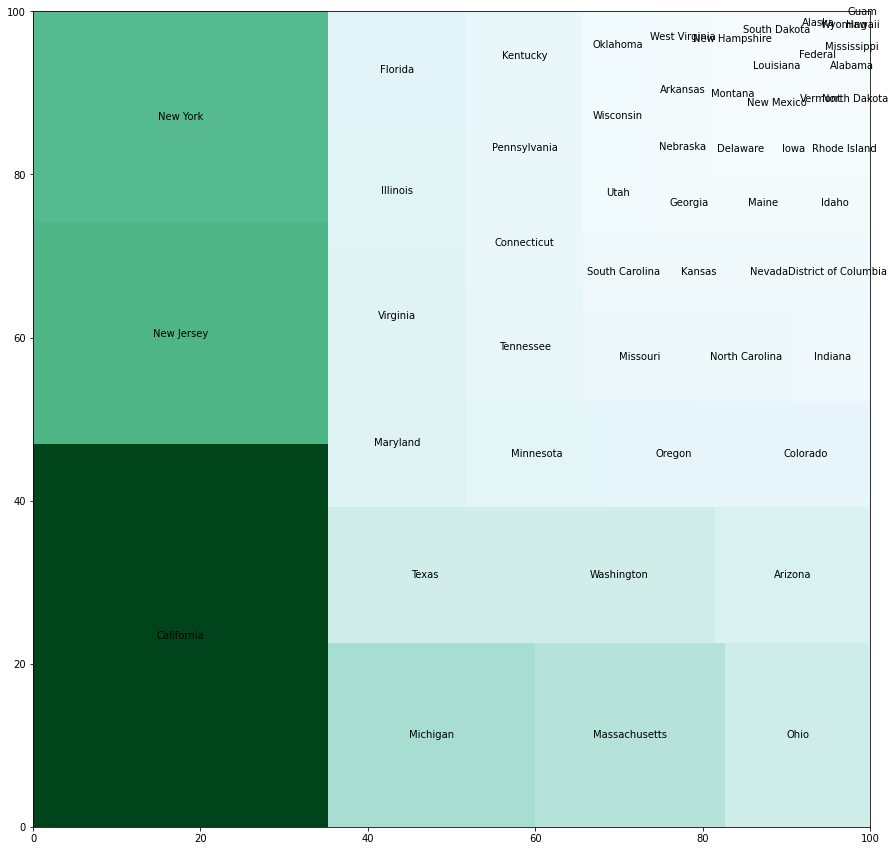

In [81]:
incidents_by_location = spark.sql("""
    SELECT STATE_NAME, count(STATE_NAME) AS NUMBER_OF_INCIDENTS
    FROM FULL_DATA
    GROUP BY STATE_NAME
    ORDER BY NUMBER_OF_INCIDENTS DESC
""").toPandas()


norm = plt.colors.Normalize(vmin = min(incidents_by_location.NUMBER_OF_INCIDENTS), vmax = max(incidents_by_location.NUMBER_OF_INCIDENTS))
colors = [plt.cm.BuGn(norm(value)) for value in incidents_by_location.NUMBER_OF_INCIDENTS]
plt.pyplot.figure(figsize=(15,15))
squarify.plot(label = incidents_by_location.STATE_NAME, sizes = incidents_by_location.NUMBER_OF_INCIDENTS, color = colors)

What is most obvious in this plot is the discrepancy in hate crime numbers by state. There are 3 states that have the most number of incidents: California, New Jersey, and New York. 

The next thing we can investigate is finding out the group that is the victim of the most hate crimes in every state: 

In [90]:
spark.sql("""
    SELECT STATE_NAME, first(BIAS_DESC), max(NUMBER_OF_INCIDENTS)  
    FROM (SELECT BIAS_DESC, STATE_NAME, COUNT(STATE_NAME) AS NUMBER_OF_INCIDENTS
        FROM FULL_DATA 
        GROUP BY STATE_NAME, BIAS_DESC
        ORDER BY STATE_NAME ASC, NUMBER_OF_INCIDENTS DESC)
    GROUP BY STATE_NAME
    ORDER BY STATE_NAME ASC
""").show(52, False)

+--------------------+------------------------------+------------------------+
|STATE_NAME          |first(BIAS_DESC)              |max(NUMBER_OF_INCIDENTS)|
+--------------------+------------------------------+------------------------+
|Alabama             |Anti-Black or African American|108                     |
|Alaska              |Anti-Black or African American|86                      |
|Arizona             |Anti-Black or African American|2302                    |
|Arkansas            |Anti-White                    |375                     |
|California          |Anti-Black or African American|11309                   |
|Colorado            |Anti-Black or African American|1341                    |
|Connecticut         |Anti-Black or African American|1319                    |
|Delaware            |Anti-Black or African American|413                     |
|District of Columbia|Anti-Gay (Male)               |604                     |
|Federal             |Anti-Black or African American

As we had previously seen, in most states, the groups that have suffered the most hate crimes are African-Americans. Some states however, have other groups and so we should check to see what those states are:

In [96]:
spark.sql("""
    SELECT STATE_NAME, BIAS_DESC, NUMBER_OF_INCIDENTS     
    FROM  (SELECT STATE_NAME, first(BIAS_DESC) AS BIAS_DESC, max(NUMBER_OF_INCIDENTS) AS NUMBER_OF_INCIDENTS 
        FROM (SELECT BIAS_DESC, STATE_NAME, COUNT(STATE_NAME) AS NUMBER_OF_INCIDENTS
            FROM FULL_DATA 
            GROUP BY STATE_NAME, BIAS_DESC
            ORDER BY STATE_NAME ASC, NUMBER_OF_INCIDENTS DESC)        
        GROUP BY STATE_NAME
        ORDER BY STATE_NAME ASC)
    WHERE BIAS_DESC NOT LIKE "Anti-Black or African American"
""").show(52, False)

+--------------------+------------------------+-------------------+
|STATE_NAME          |BIAS_DESC               |NUMBER_OF_INCIDENTS|
+--------------------+------------------------+-------------------+
|Arkansas            |Anti-White              |375                |
|District of Columbia|Anti-Gay (Male)         |604                |
|Guam                |Anti-Asian              |2                  |
|Hawaii              |Anti-White              |39                 |
|Mississippi         |Anti-Physical Disability|52                 |
|Montana             |Anti-White              |140                |
|New York            |Anti-Jewish             |7742               |
|South Dakota        |Anti-White              |134                |
|Utah                |Anti-White              |338                |
|West Virginia       |Anti-White              |341                |
+--------------------+------------------------+-------------------+



Most of the states that feature in this table are relatively smaller in population. The one exception to that is New York, which has a very high number of hate crimes against Jewish people in the past 30 years. 

We can now investigate the different types of offenses in the dataset, we are going to focus on the top 10 types: 

In [112]:
type_of_incident = spark.sql("""
    SELECT OFFENSE_NAME, COUNT(INCIDENT_ID) AS NUMBER_OF_INCIDENTS
    FROM FULL_DATA
    GROUP BY OFFENSE_NAME
    ORDER BY NUMBER_OF_INCIDENTS DESC
""") \
    .toPandas()

<AxesSubplot:>

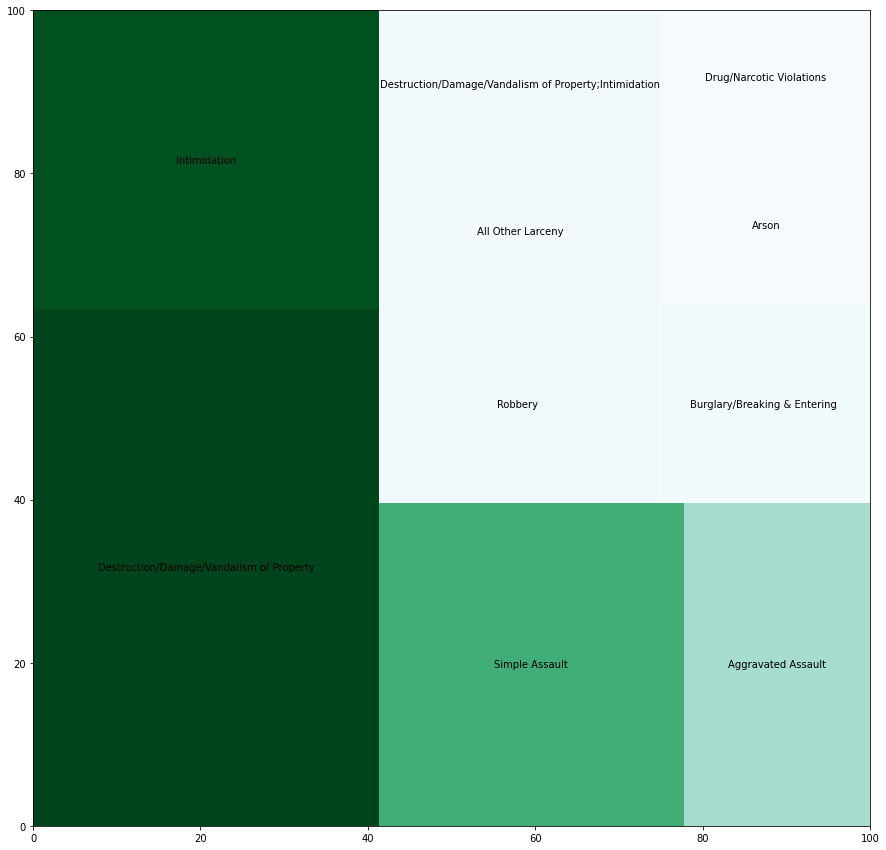

In [116]:


norm = plt.colors.Normalize(vmin = min(type_of_incident.NUMBER_OF_INCIDENTS), vmax = max(type_of_incident.NUMBER_OF_INCIDENTS))
colors = [plt.cm.BuGn(norm(value)) for value in type_of_incident.NUMBER_OF_INCIDENTS]
plt.pyplot.figure(figsize=(15,15))
squarify.plot(label = type_of_incident.OFFENSE_NAME[:10], sizes = incidents_by_location.NUMBER_OF_INCIDENTS[:10], color = colors)

Again, there is a lot of variation in the data between the 10 highest offense types. We can see that the highest one is destruction of property, and the 10th highest type of offense is drug/narcotic violation.

We are now going to take a look at the agencies that make the arrests:

In [10]:
spark.sql("""
    SELECT COUNT(DISTINCT(PUB_AGENCY_NAME))
    FROM FULL_DATA
""").show()

+-------------------------------+
|count(DISTINCT PUB_AGENCY_NAME)|
+-------------------------------+
|                           6532|
+-------------------------------+



We can see that we have over 6500 different agencies, we can now check to see the top 10 in terms of arrests:

In [14]:
spark.sql("""
    SELECT PUB_AGENCY_NAME, COUNT(INCIDENT_ID) AS NUMBER_OF_INCIDENTS
    FROM FULL_DATA
    GROUP BY PUB_AGENCY_NAME
    ORDER BY NUMBER_OF_INCIDENTS DESC
    LIMIT 10
""").show(truncate = False)

+--------------------------------+-------------------+
|PUB_AGENCY_NAME                 |NUMBER_OF_INCIDENTS|
+--------------------------------+-------------------+
|New York                        |10717              |
|Los Angeles                     |8578               |
|Boston                          |4518               |
|Phoenix                         |3951               |
|San Francisco                   |3400               |
|Suffolk County Police Department|2588               |
|Columbus                        |2375               |
|San Diego                       |2289               |
|Nassau                          |2250               |
|State Police:                   |2239               |
+--------------------------------+-------------------+



This agency name gives us more granular data on where the crimes are taking place, since they denominate city police agencies names. So we are going to combine this data to check on the largest 3 states in terms of crime: California, New York, and New Jersey. We will check to see the cities with the most number of crimes within those states:

In [27]:
plt.pyplot.figure(figsize=(15,15))

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<AxesSubplot:xlabel='PUB_AGENCY_NAME', ylabel='NUMBER_OF_INCIDENTS'>

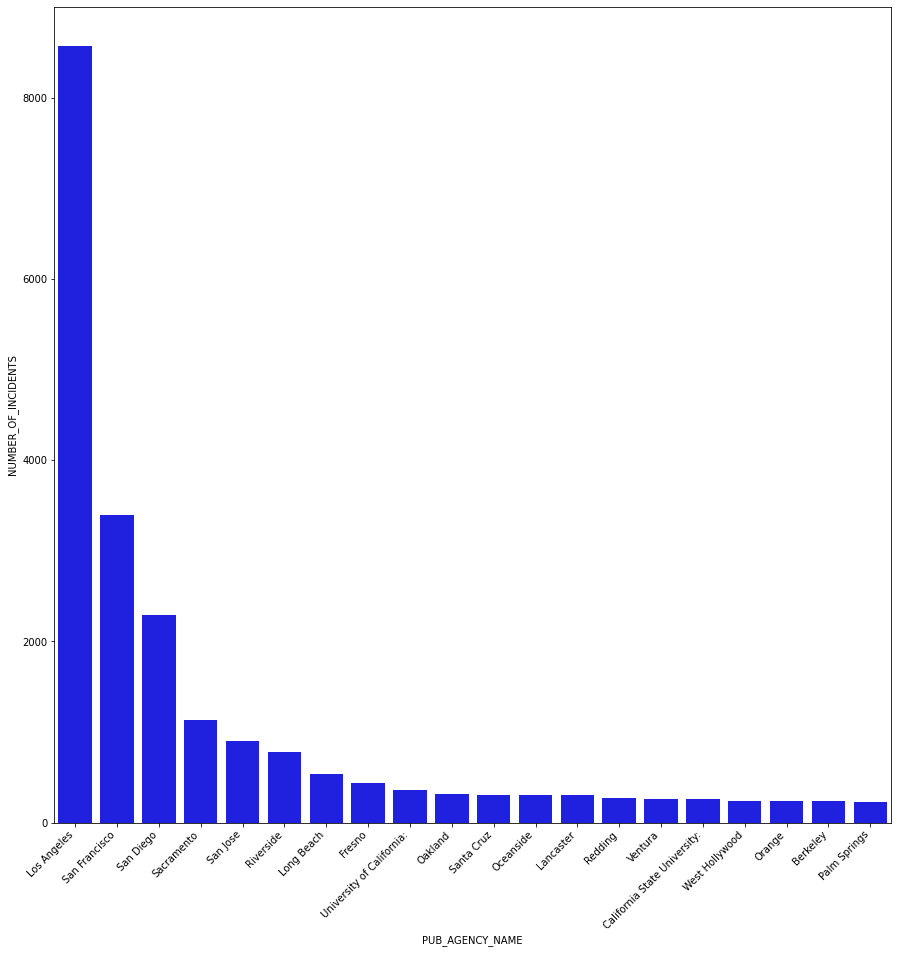

In [32]:
CA_crime = spark.sql("""
    SELECT PUB_AGENCY_NAME, COUNT(INCIDENT_ID) AS NUMBER_OF_INCIDENTS
    FROM FULL_DATA
    WHERE STATE_NAME LIKE 'California'
    GROUP BY PUB_AGENCY_NAME
    ORDER BY NUMBER_OF_INCIDENTS DESC
""").toPandas()
plt.pyplot.figure(figsize=(15,15))
_ = sns.barplot(x = 'PUB_AGENCY_NAME',
            y = 'NUMBER_OF_INCIDENTS',
            data = CA_crime[:20],
           color = 'blue')
_.set_xticklabels(_.get_xticklabels(),
                  rotation = 45,
                  horizontalalignment = 'right')
_

<AxesSubplot:xlabel='PUB_AGENCY_NAME', ylabel='NUMBER_OF_INCIDENTS'>

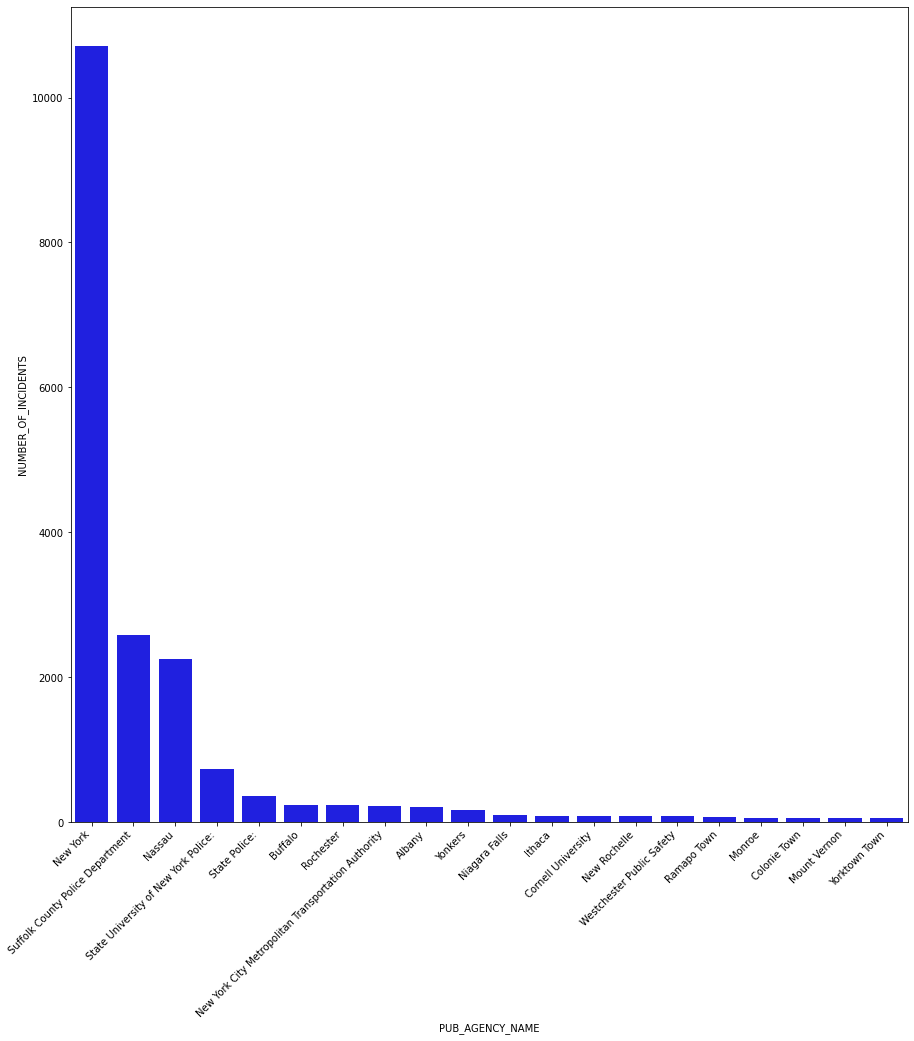

In [33]:
NY_crime = spark.sql("""
    SELECT PUB_AGENCY_NAME, COUNT(INCIDENT_ID) AS NUMBER_OF_INCIDENTS
    FROM FULL_DATA
    WHERE STATE_NAME LIKE 'New York'
    GROUP BY PUB_AGENCY_NAME
    ORDER BY NUMBER_OF_INCIDENTS DESC
""").toPandas()

plt.pyplot.figure(figsize=(15,15))
_ = sns.barplot(x = 'PUB_AGENCY_NAME',
            y = 'NUMBER_OF_INCIDENTS',
            data = NY_crime[:20],
           color = 'blue')
_.set_xticklabels(_.get_xticklabels(),
                  rotation = 45,
                  horizontalalignment = 'right')
_

<AxesSubplot:xlabel='PUB_AGENCY_NAME', ylabel='NUMBER_OF_INCIDENTS'>

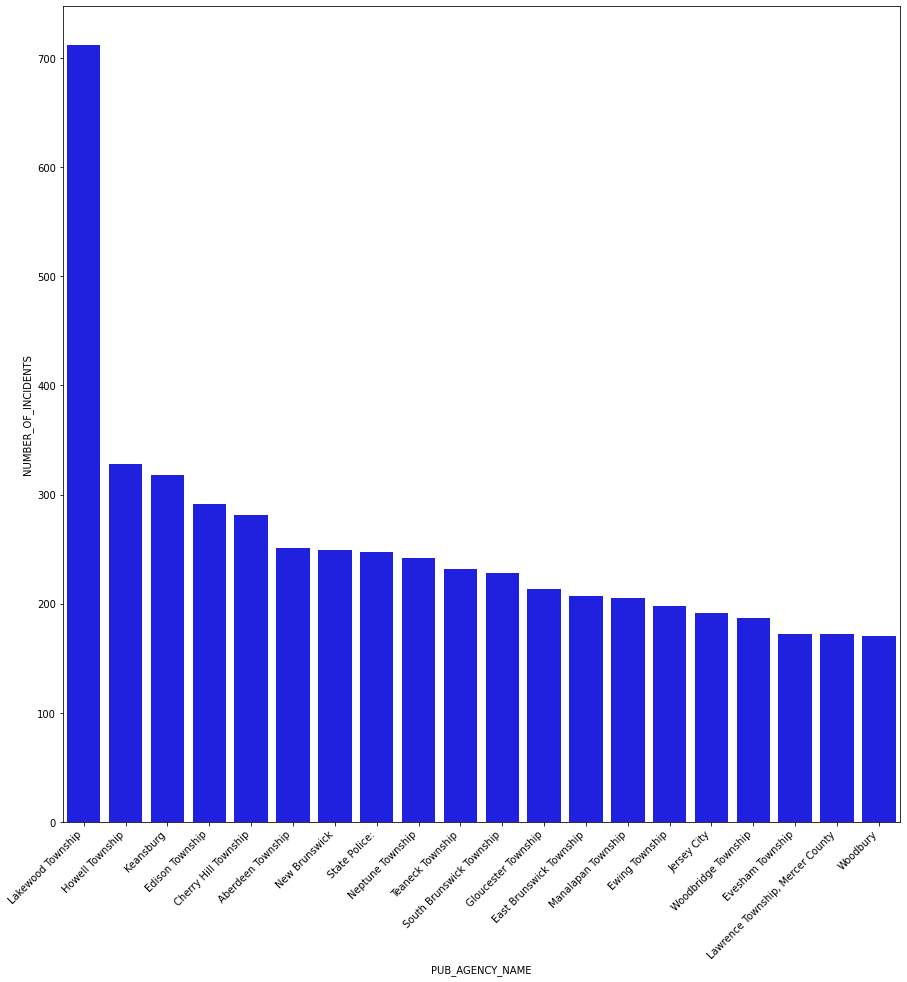

In [34]:
NJ_crime = spark.sql("""
    SELECT PUB_AGENCY_NAME, COUNT(INCIDENT_ID) AS NUMBER_OF_INCIDENTS
    FROM FULL_DATA
    WHERE STATE_NAME LIKE 'New Jersey'
    GROUP BY PUB_AGENCY_NAME
    ORDER BY NUMBER_OF_INCIDENTS DESC
""").toPandas()

plt.pyplot.figure(figsize=(15,15))
_ = sns.barplot(x = 'PUB_AGENCY_NAME',
            y = 'NUMBER_OF_INCIDENTS',
            data = NJ_crime[:20],
           color = 'blue')
_.set_xticklabels(_.get_xticklabels(),
                  rotation = 45,
                  horizontalalignment = 'right')
_